In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tkinter.filedialog import askopenfilename, askdirectory
from scipy import optimize
import os
import glob

save_folder = "G:/DREAM/from_github/thesis/Figures/optical_validation/"
extension= ".png"

%matplotlib inline
from statsmodels.regression import linear_model
from statsmodels.api import add_constant
from scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import binary_erosion

from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects

import tifffile as tiff
from tqdm import tqdm
import alienlab.plot
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/optical_validation/"
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"



sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

from scipy.fftpack import fft2
from scipy.fftpack import ifft2

from numpy.fft import fftshift, ifftshift

from scipy.fftpack import fft2 as fft
from numpy.fft import fftshift, ifftshift


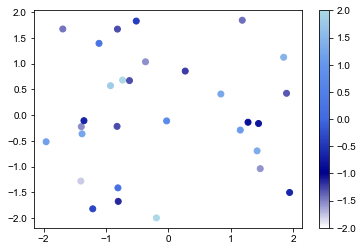

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [-2., -1,0, 1, 2]
colors = ["w","darkblue","royalblue", 'cornflowerblue', 'lightblue']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
blue_map = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.scatter(x,y,c=c, cmap=blue_map, norm=norm)
plt.colorbar()
plt.show()

In [3]:

def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S= a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * np.exp(-xdata/tau) + y0

def residuals(parameters, x_data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters,x_data) - y_observed


@delayed
@wrap_non_picklable_objects
def get_tau(trig, fluo, time_array, volt, points_per_period, sample_rate, residuals, exp_decay, threshold_ticks = 1e0, averaging = False, N_avg = 0, plot = False):
    
    trig_shift = np.roll(trig, 1)
    diff = trig-trig_shift
    tau_list = []

    trig_diff = np.abs(diff) > threshold_ticks #PARAMETER HERE

    ticks = np.nonzero(trig_diff)[0].tolist()
    ticks.append(-1)
    first = ticks[0]
    for second in ticks[1:]:
        if second - first < (points_per_period // 2):  #PARAMETER HERE
            ticks.remove(second)
        else: 
            first = second

    print(ticks)
    first = ticks[0]
    for second in ticks[1:]:
        fluo_transition = fluo[first:second]
        time_transition = np.linspace(0, second - first - 1, second - first)
        x0 = [1e5, (second-first)/8, 1]
        OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time_transition, fluo_transition, exp_decay))
        parameters_estimated = OptimizeResult.x
        tau = parameters_estimated[1]

        #conditions on tau too low or too high for the second, more accurate, fit, because we will fit on a signal that lasts 5*tau
        if tau >  (second-first)//10: #if too high
            tau =  (second-first)//10
        if tau < 3: #if too low, increase it
            tau = 5
        x0 = parameters_estimated #initial guess: parameters from previous fit
        #second fit
        OptimizeResult  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time_transition[0:int(tau*5)], fluo_transition[0: int(tau*5)], exp_decay))
        parameters_estimated = OptimizeResult.x


        # How good are the parameters I estimated?
        tau_list.append(parameters_estimated[1]/sample_rate)
        first = second

    return tau_list


def extract_tau_mean(folder, mask):
    video = tiff.imread(folder + "/video.tiff")
    timing = np.load(folder + "/video_timing.npy")
    timing = timing-timing[0]
    sample_rate = len(timing)/(timing[-1]-timing[0])
    to_evaluate = video[:,mask.flatten()]
    get_tau(trig, to_evaluate[:,i], timing, 3.3, points_per_period, sample_rate, residuals, exp_decay, 0.5)

def extract_tau_video(folder, mask, points_per_period, name):
    video = tiff.imread(folder + "/video.tiff")
    timing = np.load(folder + "/video_timing.npy")
    timing = timing-timing[0]
    sample_rate = len(timing)/(timing[-1]-timing[0])
    print(sample_rate)
    N, L, H = video.shape

    tau_480_map = np.zeros((L, H))
    tau_405_map = np.zeros((L, H))


    video_downscaled = []
    for i in range(video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (10, 10)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]
    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

    to_evaluate = video_downscaled[:,mask.flatten()]
    #plt.xlabel("time")
    #plt.ylabel('mean fluo')
    #fig = plt.plot(timing, np.mean(video_downscaled, axis = 1))
    #plt.savefig(save_folder + "/fluorescence_"+name+extension)

    trig = np.mean(video_downscaled, axis = 1)
    tau_lists = Parallel(n_jobs = -1 )(get_tau(trig, to_evaluate[:,i], timing, 3.3, points_per_period, sample_rate, residuals, exp_decay, 0.5) for i in tqdm(range(to_evaluate.shape[1])))
    
    return tau_lists

def get_mask(folder_blue, iteration = 4, thresh=2):
    reader = imageio.get_reader(glob.glob(folder_blue + "/video.tiff")[0])
    im_read =  reader.get_data(0)
    mask_full =im_read>thresh
    mask = downscale_local_mean(mask_full, (10, 10))
    mask = mask>0.5
    mask = binary_erosion(mask, iterations= iteration)
    plt.imshow(im_read)
    plt.figure()
    plt.imshow(mask)
    return mask, im_read


    
def plot_map(I_000, I_000_map, save_name, xlabel, limits = (0,0)):

    if limits==(0,0):
        Q1 = np.quantile(I_000, 0.01)
        Q3 = np.quantile(I_000, 0.95)
    else: 
        Q1 = limits[0]
        Q3 = limits[1]
    I_000_map[I_000_map <= Q1 ] = Q1
    I_000_map[I_000_map >= Q3 ] = Q3
    p.ylabel = "counts"
    p.xlabel = xlabel
    f = p.image_scale(I_000_map, label =xlabel)
    p.save_name = save_name + "_image"
    p.saving(f)
    I_000_distrib = I_000[(I_000>Q1)*(I_000<Q3)].flatten()



    fig = p.set_figure("%d", "%d")
    ax = plt.gca()

    _, bins, _ = plt.hist(I_000_distrib, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")

    p.save_name = save_name + "_hist"
    p.saving(fig)


    return I_000_map, I_000_distrib

def plot_tau(tau_lists, save_name):
    tau_lists_distr = crop_outliers(tau_lists)

    fig = plt.figure(figsize = (10,11))
    ax = plt.gca()
    plt.xlabel(r"Relaxation time (s)", fontsize = 36)
    plt.ylabel("", fontsize = 36)
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
    _, bins, _ = plt.hist(tau_lists_distr, 15, density= False, alpha=1, facecolor = "white", edgecolor = "black")
    plt.savefig(save_folder + "/hist_tau_" + save_name)



def crop_outliers(X, q1=0.1, q3=0.99):

    Q1 = np.quantile(X, q1)
    Q3 = np.quantile(X, q3)
    X[X<Q1]=Q1
    X[X>Q3]=Q3
    return X

def prepare_input(X, mask):
    Im = np.copy(X)
    Im[mask] = crop_outliers(Im[mask]) 

    Im = Im*mask
    Im[Im==0] = np.median(Im[mask])
    return Im

def get_traces(folder, save_name, BP=False):
    video = tiff.imread(folder+ "/video.tiff")
    timing = np.load(folder + "/video_timing.npy")
    timing = timing-timing[0]
    sample_rate = len(timing)/(timing[-1]-timing[0])
    mask = video[0]>2
    video = video.reshape(video.shape[0], -1)
    to_evaluate = np.mean(video[:,mask.flatten()], axis = 1)


    fig = p.set_figure("%d", "%d")
    plt.plot(timing, to_evaluate, "k", label = "Dronpa 2 fluorescence")
    if BP==False:
        plt.plot(timing, (to_evaluate>to_evaluate.mean()).astype(float)*to_evaluate.max(), "grey", linestyle = "--", label = "blue light excitation")
    else:
        plt.plot(timing, [np.mean(to_evaluate)*2]*len(timing), "blue", label = "blue light excitation")
        plt.plot(timing, (to_evaluate>np.mean(to_evaluate)).astype(float)*to_evaluate.mean()*2, "purple", label = "purple light excitation")
    
    plt.plot(timing, to_evaluate, "k", label = "Dronpa 2 fluorescence")


    plt.xlabel("t ($s$)")
    plt.ylabel("$S$ (a.u.)")
    p.save_name = save_name
    u = p.saving(fig)
    
def crop(im, x,y, sx = 0, sy = 0):
    L,H =im.shape
    im = np.roll(im, sx, axis = 0)
    im = np.roll(im, sy, axis=1)
    dl = int((L-x*L)//2)
    dh = int((H-y*H)//2)
    print(dl, dh)
    im = im[dl:L-dl,dh:H-dh]
    
    return im


# Only blue

In [4]:
folder_blue = askdirectory()

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-06-16_13_38_D2_calib_video/"

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-09-02_16_19_D2_calib_video/"
#"G:/DREAM/from_github/PAMFluo/Experiments/2022-08-03_19_09_D2_calib_video"
#"G:/DREAM/from_github/PAMFluo/Experiments/2022-07-04_18_16_D2_calib_video_B/"
name = "D2_micro_ENS_mouette_"

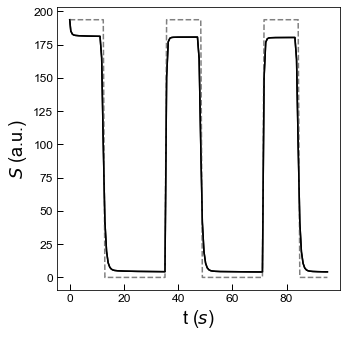

<Figure size 432x288 with 0 Axes>

In [5]:


get_traces(folder_blue, "blue_light_excitation")


0 14


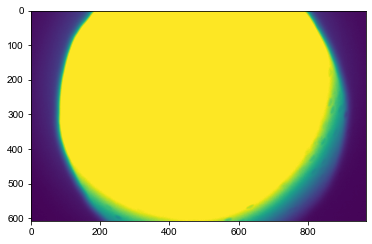

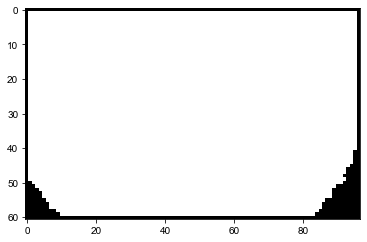

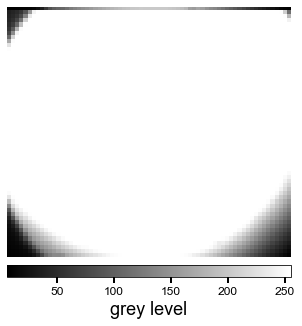

<Figure size 432x288 with 0 Axes>

In [6]:
mask, im_read = get_mask(folder_blue, iteration = 1, thresh = 5)
im_d = downscale_local_mean(im_read, (10, 10))

L,H= im_d.shape
plt.set_cmap('gray')
fig = p.image_scale(crop(im_d, 1, L/(0.9*H), 1, 2 ), label = 'grey level')
p.save_name = 'initial_image_D2_microscope'
p.saving(fig)
plt.set_cmap('viridis')


im_read.shape

In [7]:
save_name = "_blue"

tau_lists = extract_tau_video(folder_blue, mask, points_per_period = 200, name = save_name)
tau_480 = np.mean(np.array(tau_lists)[:,0::2], axis = 1)


1.6827985166512427


100%|█████████████████████████████████████████████████████████████████████████████| 5455/5455 [00:12<00:00, 453.85it/s]


In [8]:
plt.rcParams['image.cmap'] = 'Greys'


0 0
1
0 0


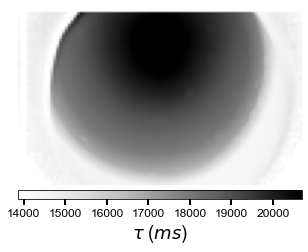

<Figure size 432x288 with 0 Axes>

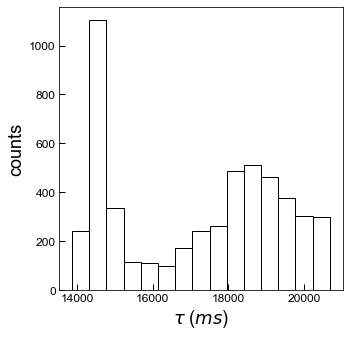

<Figure size 432x288 with 0 Axes>

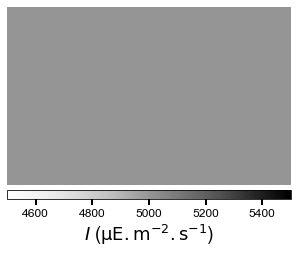

<Figure size 432x288 with 0 Axes>

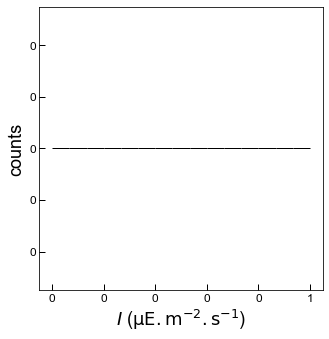

<Figure size 432x288 with 0 Axes>

In [9]:

tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480
#I, dis = plot_map(tau_480*1e3, crop(tau_480_map*1e3, 1,L/(0.9*H), 1, 2) ,  name + "_tau_pred", xlabel = r"$\tau$ ($ms$)", limits = (0,0))
I, dis = plot_map(tau_480*1e3, crop(tau_480_map*1e3, 1,1, 1, 2) ,  name + "_tau_pred", xlabel = r"$\tau$ ($ms$)", limits = (0,0))



plt.rcParams['image.cmap'] = "Greys"
I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
print(np.sum(I_480==I_480.max()))
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

#I, dis = plot_map(I_480, crop(I_480_map, 1,L/(0.9*H), 1, 2), name + "_I_480_map_B", xlabel = p.label_intensity, limits = (0,0))
I, dis = plot_map(I_480, crop(I_480_map, 1, 1, 1, 2), name + "_I_480_map_B", xlabel = p.label_intensity, limits = (5000,9000))
np.save(folder_blue + "/I_480.npy", I)
plt.set_cmap('viridis')


In [86]:
I.shape

(61, 69)

In [70]:
II = I[I>I.min()]
print(np.median(II))
M = np.mean(II)

print(M)
print(np.std(II))


8533.881242563266
7836.063401567412
1549.1859397909786


### Transfer direct

C:\Users\Alienor\AppData\Local\Temp\ipykernel_21480\1665981380.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(im_resize/I_480_map)


(-0.5, 96.5, 60.5, -0.5)

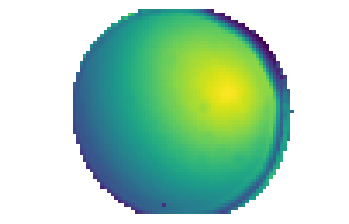

In [71]:
plt.figure()
im_resize = resize(im_read, I_480_map.shape)
plt.imshow(im_resize/I_480_map)
plt.axis("off")
#plt.savefig()

### Transfer fourier

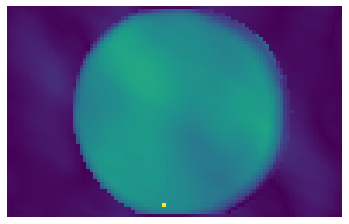

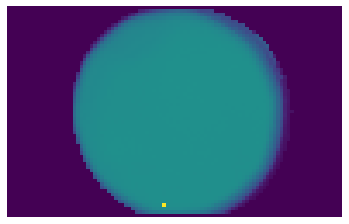

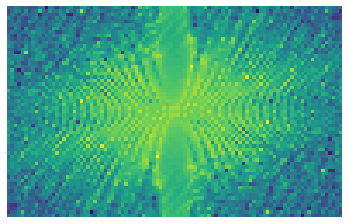

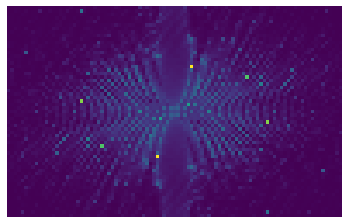

In [72]:
iF0 = 1/fft2(I_480_map)
FIcam = fft2(im_resize)
transfert_fourier = crop_outliers(FIcam*iF0, 0.01, 0.99)

def make_transfert(Icam):
    FIcam = fft2(Icam)
    FI0 = FIcam/transfert_fourier
    I0 = ifft2(FI0)
    return np.abs(I0)

plt.figure()
plt.axis("off")
plt.imshow(make_transfert(im_resize))
plt.figure()
plt.axis("off")
plt.imshow(I_480_map)

plt.figure()
plt.axis("off")
plt.imshow(fftshift(np.log(np.abs(transfert_fourier))))
plt.figure()
plt.axis("off")
plt.imshow(fftshift(np.abs(transfert_fourier)))


#https://pastel.archives-ouvertes.fr/tel-02631861
#https://gitlab.institut-langevin.espci.fr/spopoff/PyTorchAberrations/-/blob/main/Demo_correction_aberration.ipynb
#https://www.sciencedirect.com/topics/physics-and-astronomy/optical-transfer-function

## Blue and purple

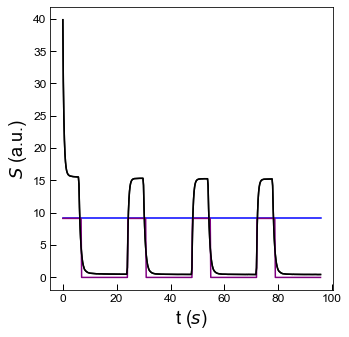

<Figure size 432x288 with 0 Axes>

In [73]:
folder_blue_purple = "G:/DREAM/from_github/PAMFluo/Experiments/2022-09-02_16_13_D2_calib_video"

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-08-10_15_06_D2_calib_video/"

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-08-03_19_02_D2_calib_video/"
#"G:/DREAM/from_github/PAMFluo/Experiments/2022-07-07_13_32_D2_calib_video"

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-07-04_18_12_D2_calib_video_BP"

#"G:/DREAM/from_github/PAMFluo/Experiments/2022-06-15_18_56_D2_calib_video/"
get_traces(folder_blue_purple, "blue_purple_light_excitation", BP=True)


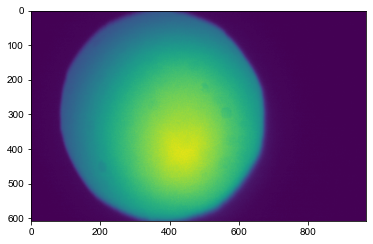

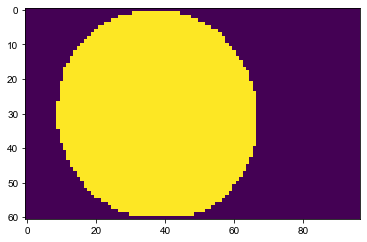

In [74]:
mask, im_read = get_mask(folder_blue_purple, iteration = 1, thresh=6)

In [75]:
tau_lists = extract_tau_video(folder_blue_purple, mask, points_per_period = 30, name =  "_blue_purple_")

5.01665477127354


100%|█████████████████████████████████████████████████████████████████████████████| 2768/2768 [00:06<00:00, 400.15it/s]


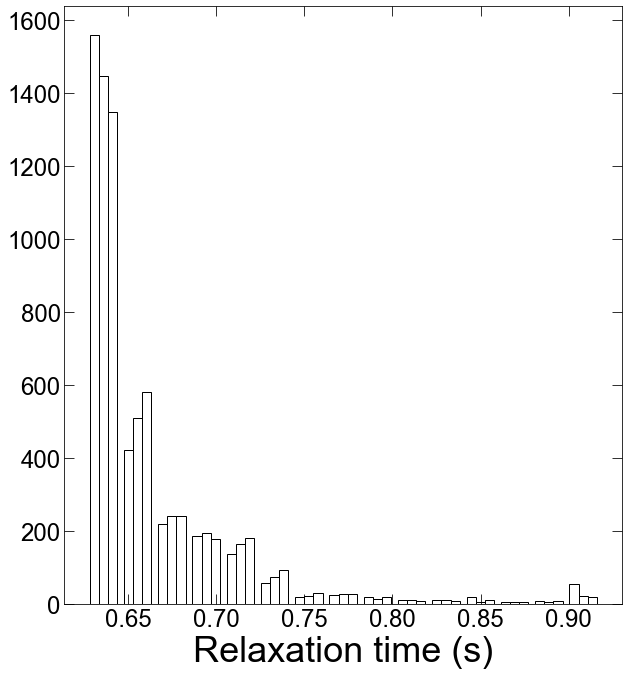

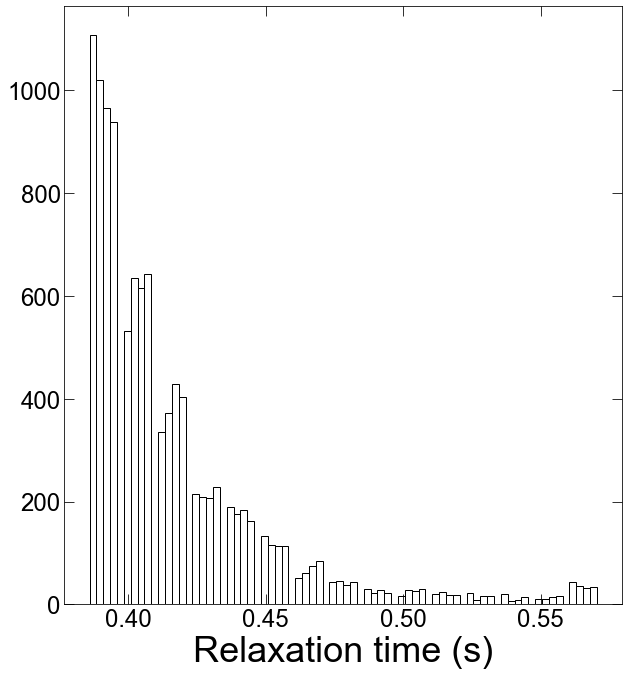

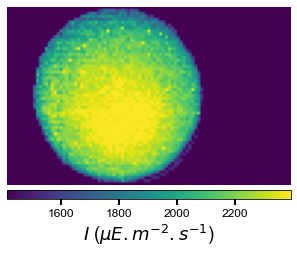

<Figure size 432x288 with 0 Axes>

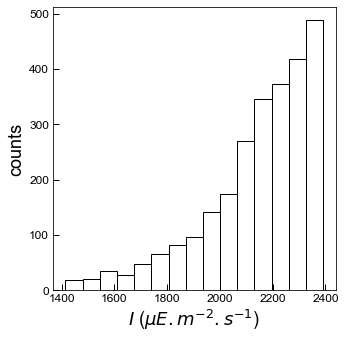

<Figure size 432x288 with 0 Axes>

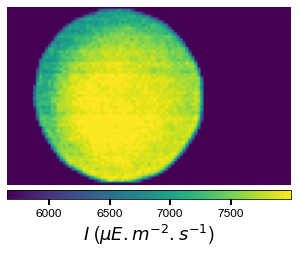

<Figure size 432x288 with 0 Axes>

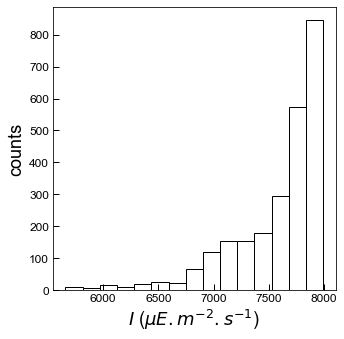

<Figure size 432x288 with 0 Axes>

In [76]:
tau_lists = np.array(tau_lists)
tau_480 = tau_lists[:,1::2]
plot_tau(tau_480, save_name + "_480")
tau_405 = tau_lists[:,0::2]
plot_tau(tau_405, save_name + "_480_405")

tau_480 = np.mean(tau_480[:,1:-1], axis = 1)
tau_405 = np.mean(tau_405[:,1:-1], axis = 1)

I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_405 = 1e6*(1/tau_405 - tau_relax -1/tau_480)/sigma_405 

I_480_map = np.zeros(mask.shape)
I_405_map = np.zeros(mask.shape)

I_480_map[mask] = I_480
I_405_map[mask] = I_405

I405, d = plot_map(I_405, I_405_map, "I_405_map_BP", xlabel=p.label_intensity, limits = (0,0))
I480, d = plot_map(I_480, I_480_map, "I_480_map_BP", xlabel=p.label_intensity, limits = (0, 0))



In [77]:
II405 = I405[I405>I405.min()]
II480 = I480[I480>I480.min()]
print(np.median(II405))
print(np.mean(II405))
print(np.std(II405))
print(np.median(II480))
print(np.mean(II480))
print(np.std(II480))

2205.223658159457
2156.698419450013
208.03818085743916
7774.4660034829085
7617.438203224464
413.1814306073796


### Transfert Fourier

In [78]:

im = np.mean(images[4:-1], axis = 0)
im = downscale_local_mean(im, (10, 10))

maskim = im>1
maskim = binary_opening(maskim)

I0 = prepare_input(I_480_t, maskim)
Icam = prepare_input(im, maskim)
plt.figure()
plt.imshow(I0)

plt.figure()
plt.imshow(Icam)

#iFI0 = crop_outliers(1/fft2(I0))
#FIcam = crop_outliers(fft2(Icam))
#transfert_fourier = crop_outliers(FIcam*iFI0)
iF0 = 1/fft2(I0)
FIcam = fft2(Icam)
transfert_fourier = crop_outliers(FIcam*iF0, 0.001, 0.999)

def make_transfert(Icam):
    FIcam = fft2(Icam)
    FI0 = FIcam/transfert_fourier
    I0 = ifft2(FI0)
    return np.abs(I0)

plt.figure()
plt.imshow(make_transfert(Icam))
plt.figure()
plt.imshow(Icam)





plt.figure()



plt.imshow(np.log(np.abs(fftshift(ifft2(transfert_fourier)))))
    

NameError: name 'images' is not defined

In [35]:
reader = imageio.get_reader(glob.glob(folder_blue + "/video.tiff")[0])
im_read =  reader.get_data(0)
mask_full =im_read>20
mask = downscale_local_mean(mask_full, (10, 10))
mask = mask>0.5
mask = binary_erosion(mask, iterations= iteration)

NameError: name 'iteration' is not defined